[[0.         0.5        0.5        0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         1.        ]
 [0.5        0.         0.5        0.        ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.         1.        ]]
[[       nan 0.80454611 0.01522519        nan]
 [       nan 0.66083085 0.11315632 0.04518728]
 [       nan        nan        nan 0.04064632]
 [0.91660782        nan 0.26772908        nan]
 [0.94368901 0.5457637         nan        nan]
 [       nan        nan 0.96672015 0.0844141 ]
 [0.75237764 0.17718315        nan        nan]
 [       nan        nan        nan 0.40195885]]
에피소드 : 0, 스텝 : 94 
에피소드 : 1, 스텝 : 4 
에피소드 : 2, 스텝 : 4 
에피소드 : 3, 스텝 : 4 
에피소드 : 4, 스텝 : 4 
에피소드 : 5, 스텝 : 4 
에피소드 : 6, 스텝 : 4 
에피소드 : 7, 스텝 : 4 
에피소드 : 8, 스텝 : 4 
에피소드 : 9, 스텝 : 4 


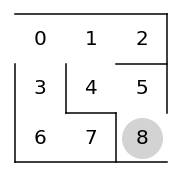

In [4]:
from matplotlib import figure
from matplotlib.figure import Figure
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML 

#세타 초기값
#상,우,하,좌
theta_0 = np.array([
                   [np.nan,1,1,np.nan], #0
                   [np.nan,1,1,1],#1
                   [np.nan,np.nan,np.nan,1],#2
                   [1,np.nan,1,np.nan],#3
                   [1,1,np.nan,np.nan],#4
                   [np.nan,np.nan,1,1],#5
                   [1,1,np.nan,np.nan],#6
                   [np.nan,np.nan,np.nan,1]])#7
#세타를 정책으로 변환
def get_pi(theta):
    #비율계산
    [m,n]=theta.shape
    pi =np.zeros((m,n))
    for i in range(0,m):
        pi[i,:] =theta[i,:] / np.nansum(theta[i,:])
    pi = np.nan_to_num(pi)
    return pi

#세타의 초기값을 정책으로 변환
pi_0 = get_pi(theta_0)
print(pi_0)

def get_s_next(s,a):
    if a==0:#상
        return s-3 
    elif a ==1:#우
        return s+1
    elif a==2: #하
        return s+3
    elif a==3: #좌
        return s-1 

#행동 가치 함수 준비
[a, b] = theta_0.shape
Q = np.random.rand(a,b) * theta_0
print(Q)

def get_a(s,Q,epsilon,pi_0):
    if np.random.rand() < epsilon:
        #랜덤으로 행동 선택
        return np.random.choice([0,1,2,3], p = pi_0[s])
    else:
        #행동 가치 함수로 행동 선택
        return np.nanargmax(Q[s])

#sarsa에 따른 행동 가치 함수 갱신
def sarsa(s,a,r,s_next,a_next,Q):
    eta =0.1 #학습계수
    gamma = 0.9 #시간할인율

    if s_next == 8:
        Q[s,a] = Q[s,a] +eta*(r-Q[s,a])
    else:
        Q[s,a] = Q[s,a] + eta*(r+gamma*(Q[s_next,a_next] - Q[s,a]))
    return Q

#Q 학습에 따른 행동 가치 함수 갱신
#seras는 행동가치 함수를 갱신할때 다음 스템의 행동을 사용하며 다음 스텝의 행동을 계산할때 E-greedy에 따른 무작위성을 포함함
#Q 학습에서는 행동 가치 함수를 갱신할 때 다음 스텝의 최대 가치 행동을 선택 e-greedy에 따른 무작위성을 포함하지 않음 
#따라서 sarsa에 비교해서 Q가 학습이 빠르게 수렴하지만 국소적인 정답에 갇히기 쉬움.
def q_learning(s,a,r,s_next,a_next,Q):
    eta = 0.1 #학습 계수
    gamma = 0.9 #시간 할인율

    if s_next == 8:
        Q[s,a] = Q[s,a] +eta*(r-Q[s,a])
    else:
        Q[s,a] = Q[s,a] + eta*(r+gamma* np.nanmax(Q[s_next, :]) - Q[s,a])
    return Q


#1에피소드 실행 -> 이력과 행동가치 함수를 얻음 이력은 [상태, 행동] 의 리스트이다 

def play(Q, epsilon, pi):
    s = 0 #상태
    a = a_next = get_a(s,Q, epsilon, pi) #행동 초기값
    s_a_history = [[0,np.nan]] #상태와 행동 이력 저장

    #에피소드 완료 시까지 반복
    while True: 
        #행동에 따른 다음 상태 얻기
        a = a_next
        s_next = get_s_next(s,a)

        #이력 갱신
        s_a_history[-1][1] = a
        s_a_history.append([s_next,np.nan])

        #종료 판정
        if s_next == 8:
            r=1
            a_next = np.nan
        else :
            r = 0
            #행동 가치 함수 Q에 따라 행동 얻기
            a_next = get_a(s_next, Q, epsilon, pi)
        #행동 가치 함수 갱신(sarsa로 하려면 sarsa() )
        Q = q_learning(s,a,r,s_next,a_next,Q)

        #종료 판정
        if s_next ==8:
            break
        else:
            s = s_next
    
    #이력과 행동가치 함수 반환
    return [s_a_history, Q]

#이제 에피소드를 반복하면서 학습 시킴
#E-greedy의 초기값은 0.5로 설정 
#학습할때 마다 epsilon = epsilon/2 로 점점 줄여감

epsilon = 0.5

for episode in range(10):
    # e-greedy 값을 점점 감소시킴
    epsilon = epsilon /2

    [s_a_history, Q] = play(Q, epsilon, pi_0)

    print('에피소드 : {}, 스텝 : {} '.format(episode, len(s_a_history)-1))

fig = plt.figure(figsize=(3,3))
plt.plot([0,3], [3, 3], color='k')
plt.plot([0,3], [0, 0], color='k')
plt.plot([0,0], [0, 2], color='k')
plt.plot([3,3], [1, 3], color='k')
plt.plot([1,1], [1, 2], color='k')
plt.plot([2,3], [2, 2], color='k')
plt.plot([2,1], [1, 1], color='k')
plt.plot([2,2], [0, 1], color='k')

#숫자
for i in range(3):
    for j in range(3):
        plt.text(0.5 + i, 2.5 - j, str(i+j*3), size =20, ha='center', va = 'center')

#원
circle, = plt.plot([0.5], [2.5], marker ='o', color = '#d3d3d3', markersize = 40)

plt.tick_params(axis = 'both', which = 'both', bottom = False, top = False, labelbottom=False, right=False, left=False, labelleft=False)

plt.box(False)
#plt.show()

#애니메이션 표시
def animate(i):
    state = s_a_history[i][0]
    circle.set_data((state % 3) + 0.5, 2.5 - int(state /3))
    return circle

anim = animation.FuncAnimation(fig, animate, frames = len(s_a_history), interval = 200, repeat = False)
HTML(anim.to_jshtml())